In [16]:
%matplotlib inline
from pyquil import Program, get_qc
from pyquil.gates import *
import numpy as np
import matplotlib.pyplot as plt
import logging
import time
from IPython.display import clear_output
import collections

In [17]:
def live_plot(data_dict, figsize=(7,5), title='Ramsey'):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Wait time')
    plt.legend(loc='upper left') # the plot evolves to the right
    plt.show()

In [18]:
def ramsey(qubit, wait_time, shots=10_000):

    p = Program(
        "DECLARE ro BIT",
        f"RESET",
        f"RX(pi/2) {qubit}",
        f"DELAY {qubit} {wait_time}e-9",
        f"RX(pi/2) {qubit}",
        f"MEASURE {qubit} ro"
    ).wrap_in_numshots_loop(shots)
        
    return p

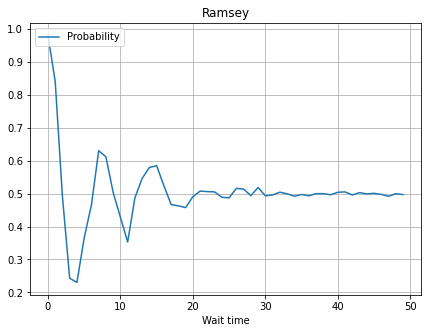

In [25]:
# runtime parameters
qubit = 0
shots = 10_000
qc = get_qc('Aspen-11')

# live logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
logging.basicConfig(filename='logs/ramsey.log', 
                    format='%(asctime)s%(msecs)03d - %(message)s', 
                    level=logging.INFO, 
                    datefmt='%d-%b-%y %H:%M:%S.')
logging.info('------------------------------------------------------------------------------   Begin')

# initialize loop
times = np.linspace(0,100000,50)
results = collections.defaultdict(list)

for wait_time in times:

    # get quil program and compile it (log compilation time)
    prog = ramsey(qubit, wait_time, shots)
    start_compile = time.time()
    exe = qc.compiler.native_quil_to_executable(prog)
    total_compile = time.time() - start_compile
    logging.info(f'Program compiled in {total_compile:.3f} s')
    
    # run the program (and time it)
    start_run = time.time()
    #result = qc.run(exe)
    # print(result)
    result = qc.run(exe).readout_data.get('ro')
    total_run = time.time() - start_run
    
    # update plot and log
    probability = np.sum(result) / shots
    results['Probability'].append(probability)
    live_plot(results)
    logging.info(f' wait time: {wait_time} \t-- probability: {probability} \t--- runtime: {total_run:.3f} seconds')
    
logging.info('Done\n')